In [1]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time

import numpy as np
import matplotlib.pyplot as plt

import sys, os

import moyra as ma
import moyra.elements as ele
import moyra.forces as ef

me.mechanics_printing()

#### Create Symbols

In [2]:
from sympy.abc import x,y,z
DoFs = 5          # total degrees of freedom

p = ma.DynamicModelParameters(DoFs)
p.L = ma.ModelSymbol(string = 'L')
p.m = ma.ModelSymbol(string = 'm')
p.Fx = ma.ModelSymbol(string = 'Fx')
p.Fy = ma.ModelSymbol(string = 'Fy')
p.Fz = ma.ModelSymbol(string = 'Fz')
p.K = ma.ModelSymbol(string = 'K')

# Attitude Parmas
p.rho = ma.ModelSymbol(value = 1.225,string = 'rho')                 # density
p.V = ma.ModelSymbol(value = 10,string = 'V')                        # velocity
p.g  = ma.ModelSymbol(value = 9.81,string = 'g')                     # gravity
p.alpha  = ma.ModelSymbol(value = 0,string = 'alpha')                     # gravity


#### Create Coordinate Systems

In [3]:
tether_frame = ma.HomogenousTransform().R_z(p.q[0]).R_x(-p.q[1]+sym.pi).Translate(0,0,p.L)
body_frame = tether_frame.R_x(p.q[2]).R_z(p.q[4]).R_y(p.q[3])

#Generate Mass Matrices
# M = ele.MassMatrix(p.m, I_xx = p.I_xx, I_yy=p.I_yy, I_zz=p.I_zz)
M = ele.MassMatrix(p.m, I_xx = 0, I_yy=0, I_zz=0)

# Generate Rigid Elements
aircraft_mass = ele.RigidElement(tether_frame,M,gravityPotential=True)
#tether_spring = ele.Spring(p.q[2],p.K)

# Generate Aircraft Forces
aircraft_forces = ef.BodyForce(p,tether_frame,Fx=p.Fx,Fy=p.Fy,Fz=p.Fz)

In [4]:
sm = ma.SymbolicModel.FromElementsAndForces(p,[aircraft_mass],ExtForces=aircraft_forces)

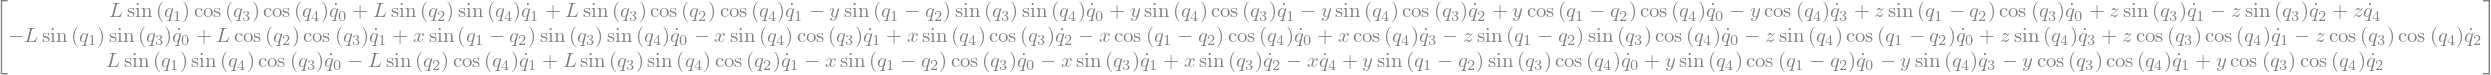

In [6]:
v_body = body_frame.Translate(x,y,z).simplify().BodyVelocity()
vb = sym.simplify(sym.Matrix(v_body[0:3]))
vb

In [7]:
def sm_to_matlab_file(sm,p,expr,func_name,file_dir):
    with open(file_dir+f"{func_name}.m",'w') as file:
        file.write(sm._gen_octave(expr,p,func_name).replace(f'function out = {func_name}(U,p)',f'function out = {func_name}(U,x,y,z,p)'))

In [8]:
file_dir = "C:\\Git\\AlbatrossOneNastran\\matlab\\+gen_vlm\\+TetheredFlight\\"
sm_to_matlab_file(sm,p,vb,'get_V',file_dir)
p.to_matlab_class(file_dir=file_dir)